<h2>Desafio 3 - Machine Learning</h2>

<h4>Objetivo</h4>
Construir un modelo de clasificación (Aprendizaje supervisado> clasificación) a partir de un dataset seleccionado.

<h3>Grupo 7</h3>
<ul>
    <li>Ignacio Mendieta</li>
    <li>Laura Jazmín Chao</li>
    <li>Juan Nicolás Capistrano</li>
    <li>Betiana Srur</li>
    <li>Marecelo Carrizo</li>
    
</ul>
<h3>Parte II - Clasificación

<a id="section_toc"></a> 
<h2> Tabla de Contenidos </h2>

[Librerías](#section_import)

[Dataset](#section_dataset)

[Selección de géneros](#section_genre_selection)

[Exploración de palabras representativas](#section_words)

[Nubes de palabras](#section_wordcloud)

[Encoder de targets](#section_ordinalEncoder)

[Stemmer](#section_stemmer)

[División de sets de entrenamiento y testeo](#section_train_test_split)

[Primera prueba de clasificación](#section_clf_1)

[Pipeline y GridSearch](#section_clf_pipeline)

$\hspace{.5cm}$[1. Logistic Regression](#section_logreg)

$\hspace{.5cm}$[2. Mulyinomial NB](#section_multiNB)


<a id="section_import"></a> 
<h3>Librerías</h3>

[volver a TOC](#section_toc)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import unidecode
from nltk.corpus import stopwords 
stop_words = stopwords.words('english');

from wordcloud import WordCloud, STOPWORDS

In [2]:
pd.set_option('display.max_columns', 100) # Para mostrar todas las columnas
# pd.set_option('display.max_rows', 100) # Para mostrar todas las filas

<a id="section_dataset"></a> 
<h3>Dataset</h3>

[volver a TOC](#section_toc)

In [3]:
data = pd.read_csv("data/movies_preprocesado.csv", low_memory=False)
data.head()

,description_clean,genre_unique
0,the adventures of a female reporter in the 1890s,romance
1,true story of notorious australian outlaw ned ...,biography
2,the fabled queen of egypts affair with roman g...,drama
3,loosely adapted from dantes divine comedy and ...,adventure
4,an account of the life of jesus christ based o...,biography


In [4]:
generos_count = data['genre_unique'].value_counts()
generos_count

drama          24473
comedy         23103
action         11971
crime           5453
horror          4998
adventure       3486
animation       2045
biography       2022
thriller        1317
romance          730
western          611
family           596
mystery          585
fantasy          486
scifi            410
musical          312
war               98
music             72
history           71
filmnoir          29
sport             16
adult              2
documentary        1
Name: genre_unique, dtype: int64

In [5]:
data.shape

(82887, 2)

In [6]:
data.columns

Index(['description_clean', 'genre_unique'], dtype='object')

<a id="section_genre_selection"></a>
<h3>Selección de géneros</h3>

[volver a TOC](#section_toc)

In [7]:
generos_count

drama          24473
comedy         23103
action         11971
crime           5453
horror          4998
adventure       3486
animation       2045
biography       2022
thriller        1317
romance          730
western          611
family           596
mystery          585
fantasy          486
scifi            410
musical          312
war               98
music             72
history           71
filmnoir          29
sport             16
adult              2
documentary        1
Name: genre_unique, dtype: int64

In [8]:
generos_count.index

Index(['drama', 'comedy', 'action', 'crime', 'horror', 'adventure',
       'animation', 'biography', 'thriller', 'romance', 'western', 'family',
       'mystery', 'fantasy', 'scifi', 'musical', 'war', 'music', 'history',
       'filmnoir', 'sport', 'adult', 'documentary'],
      dtype='object')

In [9]:
#selecciono los que tengan más de 400 películas
columns_to_drop = ['musical', 'war', 'music', 'history',
       'filmnoir', 'sport', 'adult', 'documentary']
indexes_to_drop = []

for genre in columns_to_drop:
    genre = data['genre_unique'].apply(lambda x: genre in str(x).lower());
    movies_index = list(genre[genre].index)
    for index in movies_index:
        indexes_to_drop.append(index)

In [10]:
data.drop(index=indexes_to_drop, inplace=True)

In [11]:
data['genre_unique'].value_counts()

drama        24473
comedy       23103
action       11971
crime         5453
horror        4998
adventure     3486
animation     2045
biography     2022
thriller      1317
romance        730
western        611
family         596
mystery        585
fantasy        486
scifi          410
Name: genre_unique, dtype: int64

### Selección random de 400 películas por género

In [26]:
data_selected = pd.DataFrame(columns=data.columns)
data_selected

,description_clean,genre_unique


In [27]:
for genre in data['genre_unique'].value_counts().index:
    mask = data['genre_unique']==genre
    sample = data.loc[mask,:].sample(300)
    data_selected = data_selected.append(sample)

In [28]:
data_selected.shape

(4500, 2)

In [31]:
data_selected.sample(5)

,description_clean,genre_unique
80276,all might and deku accept an invitation to vis...,animation
14648,a deranged 15th century prison colony chaplain...,horror
36787,a photographer has a single evening to find te...,comedy
12280,outpatient gary determines to get a tree for t...,family
28954,king vano rides bravely off into battle but on...,comedy


<a id="section_words"></a>
<h3>Exploración de palabras representativas por género</h3>

[volver a TOC](#section_toc)

In [ ]:
# stop_words.extend(list(STOPWORDS))

In [ ]:
# stop_words = list(set(stop_words))

In [29]:
stop_words.extend(['young', 'life', 'man', 'find', 'get'])
stop_words.append('family');
stop_words.append('la');
stop_words.append('woman');
stop_words.append('il');
stop_words.append('di');
stop_words.append('young');
stop_words.append('man');
stop_words.append('life');
stop_words.extend(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

In [30]:
vectorizer=CountVectorizer(stop_words=stop_words)

In [32]:
clases = data_selected['genre_unique'].unique()
words = []

for clase in clases:
    X=vectorizer.fit_transform(data_selected[data_selected['genre_unique']==clase]['description_clean'])
    counts=X.sum(axis=0)
    counts=np.array(counts)
    
    indices=np.argsort(counts)
    valores=np.sort(counts)
    indices=indices[0][::-1]
    valores=valores[0][::-1]
    terms=np.array(vectorizer.get_feature_names())

    print('\n Clase ', clase)
    print(terms[indices[:30]])
    


 Clase  drama
['love' 'mother' 'story' 'lives' 'wife' 'new' 'father' 'son' 'old' 'war'
 'girl' 'takes' 'live' 'meets' 'day' 'town' 'finds' 'tries' 'boy' 'death'
 'film' 'sister' 'friends' 'small' 'years' 'year' 'back' 'daughter'
 'village' 'work']

 Clase  comedy
['love' 'new' 'girl' 'friends' 'world' 'years' 'father' 'friend' 'son'
 'story' 'lives' 'school' 'time' 'couple' 'york' 'first' 'meets' 'city'
 'finds' 'decides' 'comedy' 'home' 'old' 'takes' 'together' 'small'
 'wants' 'make' 'help' 'people']

 Clase  action
['police' 'must' 'war' 'team' 'new' 'group' 'story' 'world' 'forced'
 'officer' 'son' 'former' 'love' 'prison' 'cop' 'take' 'lives' 'years'
 'finds' 'time' 'become' 'run' 'town' 'fight' 'killed' 'gang' 'father'
 'daughter' 'old' 'crime']

 Clase  crime
['murder' 'police' 'crime' 'story' 'love' 'prison' 'finds' 'death' 'gets'
 'killer' 'new' 'detective' 'years' 'gang' 'group' 'tries' 'becomes'
 'found' 'murdered' 'wife' 'past' 'goes' 'cop' 'town' 'night' 'case'
 'daughter

<a id="section_wordcloud"></a>
<h3>Nubes de palabras</h3>

[volver a TOC](#section_toc)

In [ ]:
for genre in clases:
    plt.figure(figsize=(20,12.5))
    subset = data[data['genre_unique']==genre]
    text = subset['description_clean'].values
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      collocations=False,
                      width=2500,
                      height=1800,
                      max_words=100).generate(" ".join(text))
    
    plt.subplot(2, 3, 1)
    plt.axis('off')
    plt.title(genre,fontsize=20)
    plt.imshow(cloud)



<a id="section_ordinalEncoder"></a>
<h3>Encoder de targets</h3>

[volver a TOC](#section_toc)

In [ ]:
data.head(2)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
#Cuando le paso las categorías como paramétro me tira error The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
ord_enc = OrdinalEncoder()
data["target_genre"] = ord_enc.fit_transform(data[["genre_unique"]])

data.sample(3)

<a id="section_stemmer"></a>
<h3>Stemmer</h3>

[volver a TOC](#section_toc)

In [33]:
from nltk.stem.snowball import SnowballStemmer

In [34]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence



In [35]:
data_selected['description_clean'] = data_selected['description_clean'].apply(stemming)
data_selected.head()

,description_clean,genre_unique
16178,a writer goe on a road trip across west german...,drama
29168,a mississippi district attorney and the widow ...,drama
61753,a move and intim film that follow moniqu money...,drama
55643,a social satir in which a man realiz he would ...,drama
20722,young lori anderson lost her father in a plane...,drama


<a id="section_train_test_split"></a>
<h3>División de sets de entrenamiento y testeo</h3>

[volver a TOC](#section_toc)

In [36]:
train, test = train_test_split(data_selected, random_state=42, test_size=0.30, shuffle=True)
train_text = train['description_clean']
test_text = test['description_clean']

In [37]:
train_text.head()

22615    a group of date applianc embark on a journey t...
62307            it is adapt from the hindi movi bodyguard
19554    while sheriff brackett and dr loomi hunt for m...
57684    two nineyearold girl report a flasher to the p...
28854    a polic commission enlist the aid of an eccent...
Name: description_clean, dtype: object

In [38]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3),max_features=20000, stop_words=stop_words)
vectorizer.fit(train_text)

TfidfVectorizer(max_features=20000, min_df=10, ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [39]:
X_train = vectorizer.transform(train_text)
X_test = vectorizer.transform(test_text)
y_train = train['genre_unique']
y_test = test['genre_unique']

<a id="section_clf_1"></a>
<h3>Primera prueba de clasificación</h3>

[volver a TOC](#section_toc)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

In [ ]:
genres = data['genre_unique'].unique()
len(genres)

In [41]:
classifier_log = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial', verbose=1, n_jobs=-1)
classifier_log.fit(X_train, y_train)
prediction = classifier_log.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Test accuracy is 0.2992592592592593


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


In [42]:
print(classification_report(y_test, prediction, zero_division=1))

              precision    recall  f1-score   support

      action       0.17      0.20      0.18        87
   adventure       0.22      0.17      0.20        92
   animation       0.30      0.36      0.33        81
   biography       0.40      0.56      0.47        90
      comedy       0.21      0.20      0.21        90
       crime       0.20      0.14      0.16        96
       drama       0.15      0.11      0.13       101
      family       0.30      0.41      0.35        80
     fantasy       0.24      0.22      0.23        89
      horror       0.36      0.30      0.32        98
     mystery       0.33      0.38      0.35        90
     romance       0.22      0.21      0.22        90
       scifi       0.49      0.50      0.50        94
    thriller       0.23      0.14      0.18        97
     western       0.47      0.72      0.57        75

    accuracy                           0.30      1350
   macro avg       0.29      0.31      0.29      1350
weighted avg       0.28   

In [43]:
classifier_log.classes_

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'drama', 'family', 'fantasy', 'horror', 'mystery', 'romance',
       'scifi', 'thriller', 'western'], dtype=object)

In [44]:
print(confusion_matrix(y_test, prediction))

[[17  5  9  5  3  7  3  7  2  4  6  6  5  4  4]
 [ 7 16  8  7  8  1  5 10  6  3  3  2  3  5  8]
 [ 5  4 29  6  1  0  3  8  9  0  2  3  7  1  3]
 [ 5  2  6 50  4  2  5  4  2  0  0  4  3  1  2]
 [ 7  5  5  9 18  3  7 10  3  2  3 12  0  4  2]
 [13  2  0  7  3 13  8  4  6  4 21  3  0  5  7]
 [10  9  6  8 10  2 11  9  5  5  3 15  0  5  3]
 [ 4  6  7  5  5  2  2 33  3  2  0  4  1  2  4]
 [ 3  4 10  3  4  2  6  5 20  9  3  4 10  4  2]
 [ 7  3  2  2  3  2  4  4 13 29 11  3  9  2  4]
 [ 4  1  4  5  2 11  2  1  3  4 34  2  6  8  3]
 [ 3  5  4  8 12  3  9  3  2  1  2 19  2  3 14]
 [ 7  4  4  1  4  2  2  2  2  8  5  1 47  3  2]
 [ 3  4  2  3  7 13  5  8  7  9 10  7  2 14  3]
 [ 6  2  1  5  1  2  1  1  0  1  0  1  0  0 54]]


In [45]:
conf_matrix = confusion_matrix(y_test, prediction)
conf_mat_df = pd.DataFrame(data=conf_matrix, 
                           index=classifier_log.classes_, 
                           columns=classifier_log.classes_)


In [46]:
conf_mat_df

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,horror,mystery,romance,scifi,thriller,western
action,17,5,9,5,3,7,3,7,2,4,6,6,5,4,4
adventure,7,16,8,7,8,1,5,10,6,3,3,2,3,5,8
animation,5,4,29,6,1,0,3,8,9,0,2,3,7,1,3
biography,5,2,6,50,4,2,5,4,2,0,0,4,3,1,2
comedy,7,5,5,9,18,3,7,10,3,2,3,12,0,4,2
crime,13,2,0,7,3,13,8,4,6,4,21,3,0,5,7
drama,10,9,6,8,10,2,11,9,5,5,3,15,0,5,3
family,4,6,7,5,5,2,2,33,3,2,0,4,1,2,4
fantasy,3,4,10,3,4,2,6,5,20,9,3,4,10,4,2
horror,7,3,2,2,3,2,4,4,13,29,11,3,9,2,4


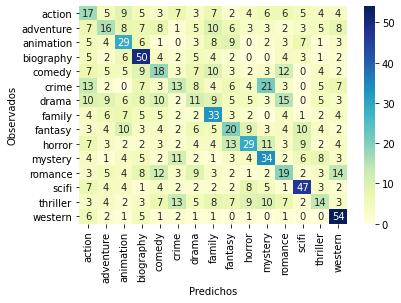

In [47]:
heatmap = sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predichos") 
plt.ylabel("Observados")
plt.show()

## SVC

In [ ]:
# from sklearn.svm import SVC
# svc = SVC(kernel = 'rbf')
# svc.fit(X_train, y_train)

# y_pred_svc = svc.predict(X_test)

# print("Accuracy of Support Vector Classifier is: {}%".format(accuracy_score(y_test, y_pred_svc) * 100))
# print("Confusion Matrix of Support Vector Classifier is: \n{}".format(confusion_matrix(y_test, y_pred_svc)))
# print("{}".format(classification_report(y_test, y_pred_svc)))

<a id="section_clf_pipeline"></a>
<h3>Pipeline y Gridsearch</h3>

[volver a TOC](#section_toc)

<a id="section_logreg"></a>
<h4>Logistic Regression</h4>

[volver a TOC](#section_toc)

In [ ]:
data_y = data['genre_unique']
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(data_x, data_y, random_state=42, test_size=0.33, shuffle=True)

In [ ]:

pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)), 
                     ('log', LogisticRegression())])

parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'log__penalty': ['l2'],
              'log__C': [0.01, 0.1, 1],
              "log__class_weight": ['balanced', None],
              "log__solver" : ['sag', 'lbfgs']
}

# skf=StratifiedKFold(n_splits=3, random_state=3, shuffle=True)


In [ ]:
grid = GridSearchCV(
    pipeline, parameters, cv=3, n_jobs=2, verbose=1)
grid.fit(X_train_pipe, y_train_pipe)

In [ ]:
print("Best parameters set:")
grid.best_estimator_.steps

In [ ]:
print("Applying best classifier on test data:")
predictions = grid.best_estimator_.predict(X_test_pipe)

print(classification_report(y_test_pipe, predictions, target_names=genres))

In [ ]:
print("Accuracy = ",accuracy_score(y_test_pipe,predictions))
print("\n")

<a id="section_multiNB"></a>
<h4>Multinomial NB</h4>

[volver a TOC](#section_toc)

In [ ]:
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', MultinomialNB(
        fit_prior=True, class_prior=None))
])
parameters1 = {
#     'tfidf__max_df': [50, 100, 200],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'tfidf__norm':['l1', 'l2']
    'clf__alpha': (1e-2, 1e-3)
}

In [ ]:
grid1 = GridSearchCV(
    pipeline1, parameters1, cv=3, n_jobs=2, verbose=1)
grid1.fit(X_train_pipe, y_train_pipe)

In [ ]:
print("Best parameters set:")
grid1.best_estimator_.steps

In [ ]:
grid1.best_score_

In [ ]:
print("Applying best classifier on test data:")
best_clf = grid1.best_estimator_
predictions1 = best_clf.predict(X_test_pipe)

print(classification_report(y_test_pipe, predictions1, target_names=genres))

In [ ]:
print("Accuracy = ",accuracy_score(y_test_pipe, predictions1))
print("\n")